Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Sunny Kumar Tuladhar"
ID = "st122336"

---

# Lab 12: Gaussian Mixture Models (GMMs)

Today we continue with unsupervised learning. One model that's more sophisticated than $k$-means is the Gaussian Mixture Model (GMM).

The GMM models a dataset $(\mathbf{x}^{(1)},\ldots,\mathbf{x}^{(m)})$ as an i.i.d. sample from the following
generative model for each sample
$\mathbf{x}^{(i)}$:

1. Sample $z^{(i)}$ from a multinomial distribution over clusters $1..k$ according to probabilities $(\phi_1,\ldots,\phi_k)$.
2. Sample $\mathbf{x}^{(i)}$ from ${\cal N}(\mathbf{\mu}_{z^{(i)}},\Sigma_{z^{(i)}})$.

The parameters are estimated using the Expectation Maximization (EM) algorithm, which begins with a guess for parameters
$\phi_1,\ldots,\phi_k,\mu_1,\ldots,\mu_k,\Sigma_1,\ldots,\Sigma_k$ then iteratively alternates between computing a soft assignment
of data to clusters then updating the parameters according to that soft assignment.

First, we'll build a GMM model for a dataset then use the model for anomaly detection.

## Example 1: Anomaly detection

Let's generate synthetic data from a mixture of Gaussians, use EM to recover as best possible the ground truth parameters, and
then use the model to find "anomalies" (unusually unlikely points according to the model). First, we set up the ground truth
parameters and generate a dataset from those ground truth parameters:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Ground truth means and covariances for the data we'll generate

means_gt = [ [1,10], [10,1], [10,10] ]
sigmas_gt = [ np.matrix([[1, 0],[0, 1]]), np.matrix([[4,0],[0,1]]),
              np.matrix([[1,0],[0,4]]) ]

# Ground truth Prior probability (phi_j) for each cluster

phi_gt = [ 0.2, 0.2, 0.6 ]

# For more interesting covariances, you can also try, for example,
# [[11.31371, -0.70711],[11.31371, 0.70711]] or
# [[11.31371, 0.70711],[-11.31371, 0.70711]].

# Size of dataset

m = 500

# number of variables

n = len(means_gt[0])

# k number of clusters/outcomes

k = len(phi_gt)

# Ground truth indices of cluster identities

Z = [0]*m

# Generate a new k-means dataset

def gen_dataset():
    X = np.zeros((m,n))
    # Generate m samples from multinomial distribution using phi_gt
    z_vectors = np.random.multinomial(1, phi_gt, size=m)  # Result: binary matrix of size (m x k)
    for i in range(m):
        # Convert one-hot representation z_vectors[i,:] to an index
        Z[i] = np.where(z_vectors[i,:] == 1)[0][0]
        # Grab ground truth mean mu_{z^i}
        mu = means_gt[Z[i]]                
        # Grab ground truth covariance Sigma_{z^i}
        sigma = sigmas_gt[Z[i]]
        # Sample a 2D point from mu, sigma
        X[i,:] = np.random.multivariate_normal(mu,sigma,1)
    return X


X = gen_dataset()

In [48]:
X.shape

(500, 2)

In [3]:
cov = np.array([[1,0],
                [0,11]])

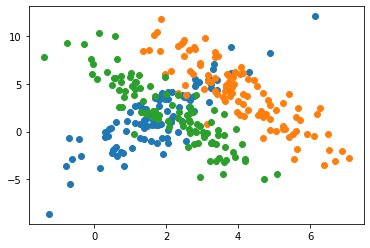

In [19]:
u = np.random.multivariate_normal([2,2],np.array([[1,4],
                                                  [4,11]]),100)
b = np.random.multivariate_normal([4,4], np.array([[1,-4],
                                                     [-4,11]]),100)
w = np.random.multivariate_normal([2,2], np.array([[1,-4],
                                                     [-4,11]]),100)

plt.scatter(u[:,0],u[:,1])
plt.scatter(b[:,0],b[:,1])
plt.scatter(w[:,0],w[:,1])

Next, the EM algorithm itself. We have an initialization step and an iterative step.

In [25]:
def init_gmm(X, k):
    m = X.shape[0]
    n = X.shape[1]
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        # Initially assign equal probability to each cluster/outcome
        Phi[j] = 1/k      
        # Ramdomly assign mean to one of the data points       
        Mu[:,j] = X[order[j],:].T
        # Initial covariance is identity matrix
        Sigma[j,:,:] = np.eye(n)    
    return Phi, Mu, Sigma


def Gaussian(X, mean, covariance):
    k = len(mean)
    X = X - mean.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * np.sum(X @ np.linalg.pinv(covariance) * X, axis=1))
    return p

def gaussian(x, mean,covariance):
    k = len(mean)
    X = (x - mean).reshape(-1,1)
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * (X.T @ np.linalg.pinv(covariance) @ X))
    return p


# Run one iteration of EM

def iterate_em_gmm(X, threshold, Phi, Mu, Sigma):
    m = X.shape[0]
    n = X.shape[1]
    k = len(Phi)
    threshold = np.reshape(np.repeat(threshold, n*k), (n,k))
    pj_arr = np.zeros((m,k))
    
    # E-step: calculate w_j^i
    W = np.zeros((m, k))
    for j in range(k):
        pj = Gaussian(X, Mu[:,j], Sigma[j])
        pj_arr[:,j] = pj
        W[:,j] = Phi[j] * pj
    
    # W tells us what is the relative weight of each cluster for each data point
    W[:,:] = W * np.tile(1/np.sum(W,1),(k,1)).T

    # M-step: adjust mean and sigma
    Phi[:] = sum(W) / m
    Mu_previous = Mu.copy()
    for j in range(k):
        # Split cluster specific W for each dimension
        Wj = np.tile(W[:,j],(2,1)).T
        # Compute Mu for each variable for each cluster
        Mu[:,j] = sum(X * Wj)/sum(Wj)
        Muj = np.tile(Mu[:,j],(m,1))
        Sigma[j,:,:] = np.matmul((X - Muj).T, (X - Muj) * Wj) / sum(W[:,j])

    if (abs(Mu-Mu_previous) <= threshold).all():
        converged = True
    else:
        converged = False

    labels = np.argmax(pj_arr, axis = 1)
    pj = np.max(pj_arr,axis=1)
    X_label = np.insert(X, 2, labels, axis=1)
    return converged, pj, X_label

Let's run the model to convergence:

In [50]:
threshold = np.matrix(.001)

Phi, Mu, Sigma = init_gmm(X, k)

converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

In [51]:
print(Phi)
print(phi_gt)

phi_gt = np.array(phi_gt).reshape(-1,1)
phi_mse = np.mean(np.min((Phi-phi_gt)**2,axis=1))

print(phi_mse)

[0.192     0.5704605 0.2375395]
[0.2, 0.2, 0.6]
0.0003335274080302182


In [52]:
print(Mu)
print(np.array(means_gt).T)

[[ 1.06127336 10.00992605  9.93705561]
 [ 9.98723214  9.97145521  1.16083754]]
[[ 1 10 10]
 [10  1 10]]


In [53]:
print('predicted sigma \n',Sigma)
print('sigmas gt \n',sigmas_gt)

predicted sigma 
 [[[0.99802047 0.16111242]
  [0.16111242 0.71154585]]

 [[1.05973414 0.09552434]
  [0.09552434 3.22984494]]

 [[4.08443213 0.13771207]
  [0.13771207 1.18475152]]]
sigmas gt 
 [matrix([[1, 0],
        [0, 1]]), matrix([[4, 0],
        [0, 1]]), matrix([[1, 0],
        [0, 4]])]


### In-class exercise (not graded, for practice)

Determine how close the estimated parmeters Phi, Mu, and Sigma are to the ground trouth values set up at the beginning of the experiment. Report your results and briefly discuss here.

It can be seen that the estimated values of Sigma, Mu, Phi are nearly same to that of the ground truth. The values of the 2nd and 3rd model's sigma_xy and sigma_yx seem to be reversed which might mean it just switched the two clusters., as the gt 2nd and 3rd models also have it switched.






Next, we continue to find outliers:

In [54]:
outlier_prob = .01
outliers = np.nonzero(pj < outlier_prob)[0]

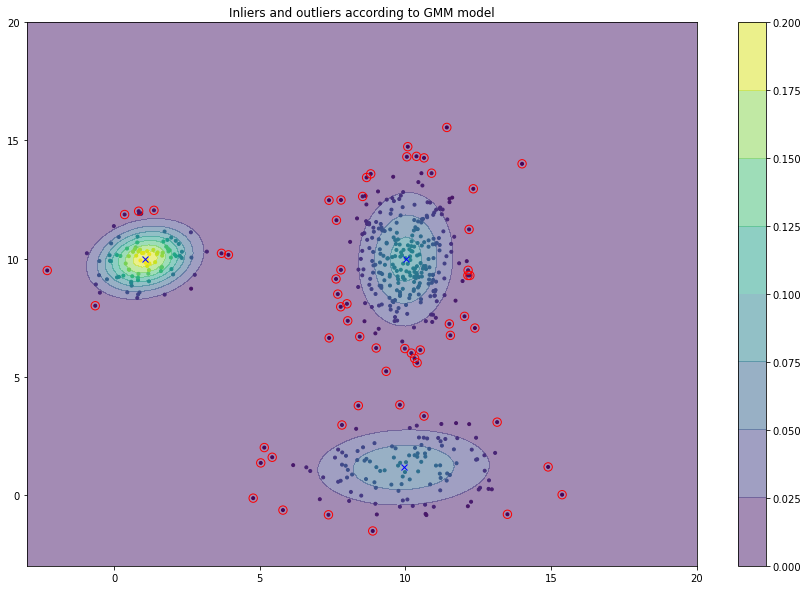

In [55]:
fig1 = plt.figure(figsize=(15,10))

xlist = np.linspace(-3, 20, 100)
ylist = np.linspace(-3, 20, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])[0]
            j = j + 1
        i = i + 1    
    ZZ = np.maximum(ZZ,Z)
cp = plt.contourf(XX, YY, ZZ,alpha=0.5)
cbar = fig1.colorbar(cp)

plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.title('Inliers and outliers according to GMM model')
plt.show()

### In-class exercise

Notice that using a hard threshold for each cluster gives us more outliers for a broad cluster than a
tight cluster. First, you'll want to understand why and explain.  Next, you'll read about
Mahalanobis distance
of a point to the mean of a multivariate Gaussian distribution and see if you can use Mahalanobis distance
to get a better notion of outliers in this dataset.

### Exercise 1.1 (10 points)

Notice that using a hard threshold for each cluster gives us more outliers for a broad cluster than a tight cluster. Understand why, and explain here.

There are 2 effects. 

1. Probability densities of different variances will result in having different thresholds for any arbitrary p value. A high variance will flatten and lower the normal curve, therefore, will have a lower threshold for a particular p value compared to a low variance distribution.
    - this is the reason why the broader cluster has more outliers when using the same threshold value for different clusters.
2. A broad cluster will take in more of the effects from the other clusters from the "w" in comparison to a tight cluster. This is because the likelihood of a datapoint from a different cluster in a tight cluster will have an extremely low value which the likelihood of a datapoint from a different cluster in a broad cluster will have a relatively larger value. Thus further increasing in variance.

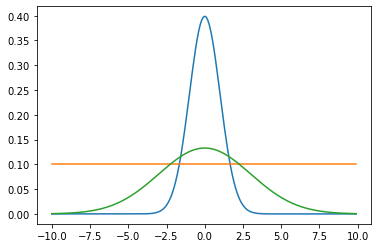

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Plot between -10 and 10 with .1 steps.
x_axis = np.arange(-10, 10, 0.1)

thresh = np.full((200,), 0.1)
plt.plot(x_axis, norm.pdf(x_axis,0,1)) #mean 0, std 1
plt.plot(x_axis, thresh)
plt.plot(x_axis, norm.pdf(x_axis,0,3)) #mean 0, std 3
plt.show()

YOUR ANSWER HERE

From the above figure we can see that the distribution with greater standard deviation covers more area outside the threshold, hence increasing the number of outliers. In the given figure the tight cluster contains increasing number of elipsies which suggests that it has lower standard deviation compared to the broad cluster. Hence the tight cluster has more inliers and the broad cluster have more outliers for high threshold.

### Exercise 1.2 (15 points)

Read about Mahalanobis distance of a point to the mean of a multivariate Gaussian distribution and see if you can use Mahalanobis distance to get a better notion of outliers in this dataset.
1. Explain what is Mahalanobis (5 points)
2. Write code Mahalanobis (10 points)

#### Explain what is Mahalanobis distance (5 points)

YOUR ANSWER HERE

The Mahalanobis distance (MD) is the distance between two points in multivariate space.
The Mahalanobis distance measures distance relative to the centroid — a base or central point which can be thought of as an overall mean for multivariate data. The centroid is a point in multivariate space where all means from all variables intersect. The larger the MD, the further away from the centroid the data point is.
It also takes into account the covariance of the data points and removes it.

The formula of Mahalanobis distance is -

$$D_M(\vec{x})=\sqrt{(\vec{x}-\vec{\mu})^T S^{-1} (\vec{x}-\vec{\mu}) }$$

It is the distance between two points which has been scaled by the eigen vectors and values of the covariance matrix. In essence, it's like transforming all the points so that the distribution becomes a standard normal distributions, then finding the length from the transformed points. 

The distance is a better way to find outliers because it aligns correctly with how z-scores work in gaussian distributions. 

An interesting thing to note is that the mahalanobis distance is actually a part of the probability function of a multivariate gaussian but unlike the probability function, the mahalanobis distance doesn't have a division by the determinant of the variance.


#### Write code to compute Mahalanobis distance between the data and their nearest means (10 points)

In [33]:
print(Sigma.shape)
print(Mu.shape)
print(X.shape)

m_distance = np.zeros((X.shape[0],Mu.shape[1]))

for kk in range(Mu.shape[1]):
    for i, x in enumerate(X):
        # get all row data from target column
        mu = Mu[:,kk]
        # get target sigma
        sig = Sigma[kk]
        # inverse matrix of sigma
        sig_inv = np.linalg.inv(sig)
        # find difference of mu and x and reshape it (if need)
        diff = (x - mu).reshape(-1, 1)
        # calculate distance from diff and sigma
        distance = np.sqrt(diff.T @ sig_inv @ diff)
        # YOUR CODE HERE
        # raise NotImplementedError()
        # keep distance
        m_distance[i,kk] = distance

# find unique of minimum m_distance and count
# hint: use np.unique and np.argmin
(unique, counts) = np.unique(np.argmin(m_distance, axis=1)), len(np.unique(np.argmin(m_distance, axis=1)))

max_z_score = 2.05
# find minimum distance
# hint: use np.min
min_distance = np.min(m_distance, axis=1)

# find outlier from min_distance
outlier = np.where(min_distance > max_z_score)

(3, 2, 2)
(2, 3)
(500, 2)


In [34]:
import sys
#np.set_printoptions(threshold=sys.maxsize)

print(Sigma.shape)
print(Mu.shape)
print(X.shape)

m_distance = np.zeros((X.shape[0],Mu.shape[1]))

for kk in range(Mu.shape[1]):
    for i, x in enumerate(X):
        # get all row data from target column
        mu = Mu[:,kk]
        # get target sigma
        sig = Sigma[kk,:,:]
        # inverse matrix of sigma
        sig_inv = np.linalg.inv(sig)
        # find difference of mu and x and reshape it (if need)
        diff = (x - mu).reshape(-1,1)
        # calculate distance from diff and sigma
        distance = np.sqrt(np.dot(np.dot(diff.T, sig_inv),diff))
        # keep distance
        m_distance[i,kk] = distance

# find unique of minimum m_distance and count
# hint: use np.unique and np.argmin

(unique, counts) = np.unique(np.argmin(m_distance,axis=1)), len(np.unique(np.argmin(m_distance,axis=1)))

max_z_score = 2.05
# find minimum distance
# hint: use np.min
min_distance = np.argmin(m_distance)
# find outlier from min_distance
outlier = np.nonzero(pj < outlier_prob)[0]
# YOUR CODE HERE
#raise NotImplementedError()

(3, 2, 2)
(2, 3)
(500, 2)


outlier [  5   9  22  27  32  34  44  59  91  92  96 105 109 116 120 129 130 131
 146 160 181 183 185 189 208 215 234 248 260 271 280 288 291 298 299 300
 313 314 336 348 368 375 383 400 416 423 451 462 470 471 479 487 497]


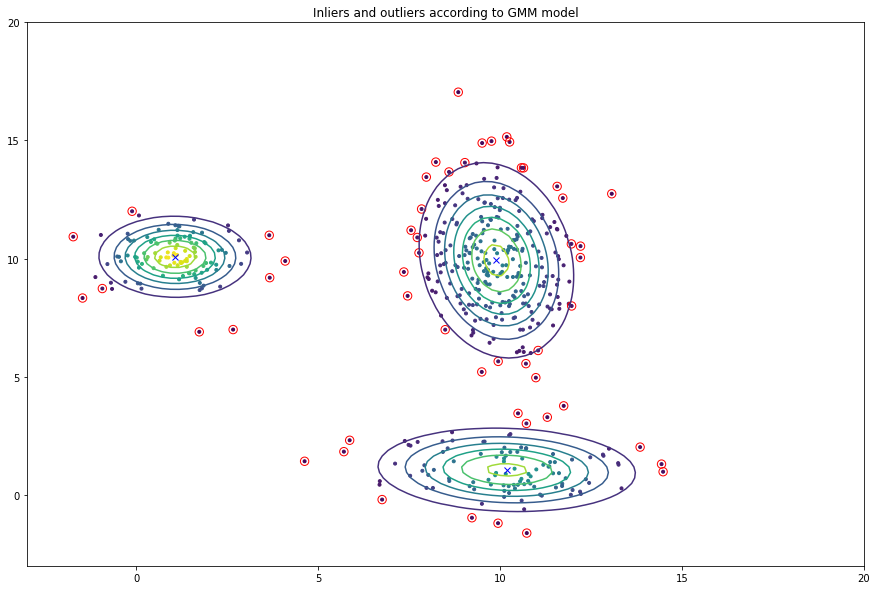

success!


In [35]:
# Test function: Do not remove
print('outlier', outlier)

fig1 = plt.figure(figsize=(15,10))

xlist = np.linspace(-3, 20, 100)
ylist = np.linspace(-3, 20, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])[0]
            j = j + 1
        i = i + 1    
    cp = plt.contour(XX,YY,Z)

plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');
plt.scatter(X[outlier,0],X[outlier,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.title('Inliers and outliers according to GMM model')
plt.show()
print('success!')
# End test function

## Example 2: Customer segmentation

In this example we will use the Kaggle customer segmentation dataset
from last week. We've included the
[Mall_Customers.csv](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)
file with this lab.

Let's stick to just two dimensions in the dataset:

In [41]:
data = pd.read_csv('Mall_Customers.csv')
data = data.drop(['CustomerID', 'Gender', 'Age'], axis = 1)
print(data.head())

   Annual Income (k$)  Spending Score (1-100)
0                  15                      39
1                  15                      81
2                  16                       6
3                  16                      77
4                  17                      40


In [42]:
X  = np.array(data, dtype=float)

n = X.shape[1]
m = X.shape[0]
k = 3

threshold = np.matrix(.01)

# Slightly different version of init_gmm due to the data format and spread
def init_gmm(X, k):
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        Phi[j] = 1/k
        Mu[:,j] = X[order[j],:].T
        Sigma[j,:,:] = np.cov(X.T)
    return Phi, Mu, Sigma


Phi, Mu, Sigma = init_gmm(X, k)

converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

In [43]:
print(Mu)

[[60.96571929 48.76221466 89.81499788]
 [55.94892304 56.25875464 14.9625518 ]]


The first row represents annual income, whereas the second row represents the spending score. These values tend to change in every iteration, so therefore it is difficult to definitively segregate the data into three categories.

In [44]:
print(Sigma.shape)
print(Mu.shape)

(3, 2, 2)
(2, 3)


Next, the visualization:

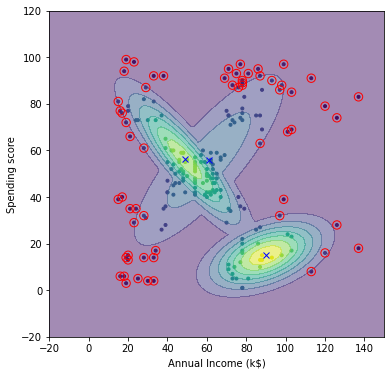

In [45]:
plt.figure(figsize=(6,6))
plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');

outlier_prob = .0002
outliers = np.nonzero(pj<outlier_prob)[0]


xlist = np.linspace(-20, 150, 100)
ylist = np.linspace(-20, 120, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)
for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])
            j = j + 1
        i = i + 1    
    ZZ = np.maximum(ZZ,Z)
cp = plt.contourf(XX, YY, ZZ,alpha=0.5)
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending score')
plt.show()

### In-class exercise (25 points)

Examine the cluster centers and determine whether you can find any reasonable interpretation of them.
Discuss in your report (5 points), and compare to the $k$-means method from last week. (20 points)

#### Interpretation of clusters (5 points)

YOUR ANSWER HERE

Examining the three cluster centers above it can be interpreted as cluster of 
- high income, low expenditure (saver),
- low income, high expenditure (spendthrift)
- average income, average expenditure. (average person)

We can also see a lot of outliers in all of the clusters

#### Run $k$-means and compare results

In [21]:
X.shape

(200, 2)

In [22]:
import random
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import pairwise_distances
from IPython.display import clear_output
import time

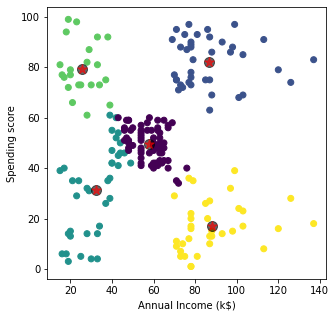

0.0


In [23]:
# 1. Initialize three random cluster centers
random.seed(400)
randomlist = random.sample(range(0, X.shape[0]),5) #using 5 clusters
centers = X[randomlist]
means =  np.zeros((centers.shape)) 

while True:
    
    # 2. Find the nearest cluster center for each point
    labels = pairwise_distances_argmin(X, centers)
        
    # 4. Find the mean of the points assigned to each cluster center
    for i in range(centers.shape[0]):
        means[i] = np.mean(X[np.where(labels == i)],axis = 0)
        
    plt.figure(figsize=(5, 5))
    plt.scatter(X[:, 0], X[:, 1], c=labels)
    plt.scatter(centers[:, 0], centers[:, 1], s=100,marker = 'o', c="black", alpha=0.6)
    plt.scatter(means[:, 0], means[:, 1], s=100,marker = '*', c="red", alpha=0.6)
    plt.xlabel('Annual Income (k$)')
    plt.ylabel('Spending score')
    plt.show()
    
    error = 0.0    
    for i in range(centers.shape[0]):
        error += ((means[i,:] - centers[i,:])**2).sum()
        
    print(error)
    if error < 1e-6:
        break
    else:
        centers = means 
    
    time.sleep(1)
    clear_output()

#raise NotImplementedError()

We can see clear 5 clusters. 
 - low income low spending score
 - high income low spending score
 - avg income avg spending score
 - low income high spending score
 - high income high spending score
 
 k-means clustering is not able to identify outliers and will assign a cluster for all points in the dataset. This might cause problems as some data points which are very far off from the clusters might skew the centers and cause inaccurate clusters.

### In-class exercise (10 points)

Do the same analysis with Mahalanobis distance as in the first example.

In [24]:
outlier = 0.01
# YOUR CODE HERE
m_distance = np.zeros((X.shape[0],Mu.shape[1]))

for kk in range(Mu.shape[1]):
    for i, x in enumerate(X):
        # get all row data from target column
        mu = Mu[:,kk]
        # get target sigma
        sig = Sigma[kk,:,:]
        # inverse matrix of sigma
        sig_inv = np.linalg.inv(sig)
        # find difference of mu and x and reshape it (if need)
        diff = (x - mu).reshape(-1,1)
        # calculate distance from diff and sigma
        distance = np.sqrt(np.dot(np.dot(diff.T, sig_inv),diff))
        # keep distance
        m_distance[i,kk] = distance

# find unique of minimum m_distance and count
# hint: use np.unique and np.argmin
(unique, counts) = np.unique(np.argmin(m_distance,axis=1)), len(np.unique(np.argmin(m_distance,axis=1)))

max_z_score = 2.  
# find minimum distance
# hint: use np.min
min_distance = np.min(m_distance, axis=1)
# find outlier from min_distance
outlier = np.where(min_distance > max_z_score)
# raise NotImplementedError()

outlier (array([  0,   4,   7,  11,  16,  19,  22,  30,  32,  33,  41, 134, 136,
       140, 156, 158, 169, 184, 192, 194, 196, 197, 198, 199]),)


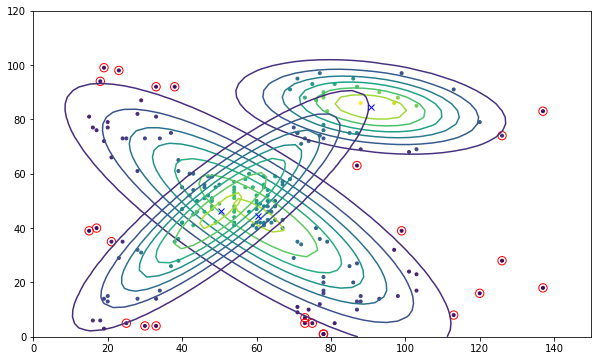

success!


In [25]:
# Test function: Do not remove
print('outlier', outlier)

plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');

plt.scatter(X[outlier,0],X[outlier,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    xlist = np.linspace(0, 150, 50)
    ylist = np.linspace(0, 120, 50)
    
    XX, YY = np.meshgrid(xlist, ylist)
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])
            j = j + 1
        i = i + 1    
    cp = plt.contour(XX, YY, Z)

plt.show()
print('success!')
# End test function

YOUR ANSWER HERE

Examining the three cluster centers above it can be interpreted as cluster of 
- high income, low expenditure (saver),
- high income, high expenditure (spendthrift)
- average income, average expenditure. (average person)


### Example 3: Customer segmentation

This example is based on [Nguyen Hanh's tutorial on Medium.com](https://medium.com/@nguyenbaha/buiding-customer-segmentation-by-gmm-from-scratch-4ea6adc3da1c). In this example we use the Kaggle [OnlineRetail.csv](https://www.kaggle.com/vijayuv/onlineretail) dataset for customer segmentation. 

In [46]:
data = pd.read_csv('Online_Retail.csv')
data = data.iloc[0:5000,:]
print(data.head())
data = data.drop(['InvoiceNo','Description', 'CustomerID'], axis = 1)

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  InvoiceDate  UnitPrice CustomerID         Country  TotalSum  
0   12/1/2010       2.55      17850  United Kingdom     15.30  
1   12/1/2010       3.39      17850  United Kingdom     20.34  
2   12/1/2010       2.75      17850  United Kingdom     22.00  
3   12/1/2010       3.39      17850  United Kingdom     20.34  
4   12/1/2010       3.39      17850  United Kingdom     20.34  


In [47]:
print(data.dtypes)

StockCode       object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
Country         object
TotalSum       float64
dtype: object


Let's view the categorical and numeric columns:

In [48]:
categorical_colmns = data.select_dtypes(include=['object']).columns
print(categorical_colmns)
numerical_colmns = data._get_numeric_data().columns
print(numerical_colmns)

Index(['StockCode', 'InvoiceDate', 'Country'], dtype='object')
Index(['Quantity', 'UnitPrice', 'TotalSum'], dtype='object')


In [49]:
def missing_percentage(data):
    """This function takes a DataFrame(df) as input and returns two columns, 
     total missing values and total missing values percentage"""
    total = data.isnull().sum().sort_values(ascending = False)
    percent = round(data.isnull().sum().sort_values(ascending = False)/len(data)*100,2)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])


missing_percentage(data)



,Total,Percent
TotalSum,48,0.96
Country,12,0.24
StockCode,0,0.00
Quantity,0,0.00
InvoiceDate,0,0.00
UnitPrice,0,0.00


Next, let's fill the "na" values with "No information" and 0

In [50]:
data[categorical_colmns] = data[categorical_colmns].fillna("No information")
data[numerical_colmns] = data[numerical_colmns].fillna(0)

print(data.head())

  StockCode  Quantity InvoiceDate  UnitPrice         Country  TotalSum
0    85123A         6   12/1/2010       2.55  United Kingdom     15.30
1     71053         6   12/1/2010       3.39  United Kingdom     20.34
2    84406B         8   12/1/2010       2.75  United Kingdom     22.00
3    84029G         6   12/1/2010       3.39  United Kingdom     20.34
4    84029E         6   12/1/2010       3.39  United Kingdom     20.34


In [51]:
data_new = data.drop(['StockCode','InvoiceDate', 'Country'], axis = 1)
data_new

,Quantity,UnitPrice,TotalSum
0,6,2.55,15.30
1,6,3.39,20.34
2,8,2.75,22.00
3,6,3.39,20.34
4,6,3.39,20.34
...,...,...,...
4995,120,0.42,50.40
4996,120,0.42,50.40
4997,120,0.42,50.40
4998,48,0.55,26.40


Now let's convert the categorical columns to numeric. Give some thought as to whether it's appropriate
to do so for all of the columns.

In [52]:
# def category_to_numeric(categorical_columns):
#     i = 0;
#     columnname = '';
#     while i < len(categorical_colmns):
#         col_idx = data.columns.get_loc(categorical_colmns[i])
#         distinct_values = data[categorical_colmns[i]].unique()
#         j = 0;    
#         for val in distinct_values:
#             idx = np.where(data[categorical_colmns[i]] == val);
#             data.iloc[idx[0],col_idx] = j            
#             j = j + 1;
#         i = i + 1;
        
        
# category_to_numeric(data[categorical_colmns])

# data = data.astype('float64')
# print(data.head())

In [53]:
Q1 = data_new.quantile(0.1) #removing the outliers completely beyond the 0.1 and 0.8 percentile for simplicity
Q3 = data_new.quantile(0.8)

#we only take data within the Quartiles
data_new = data_new[~((data < (Q1)) |(data_new > (Q3))).any(axis=1)]

<AxesSubplot:>

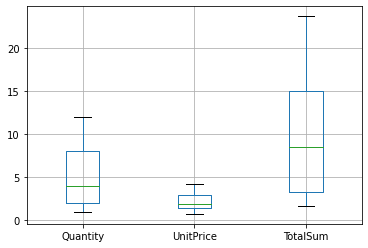

In [54]:
data_new.boxplot()

In [55]:
Mu = np.mean(data_new[numerical_colmns])
Sigma = np.std(data_new[numerical_colmns])
print(Mu)
print(Sigma)

Quantity     5.216853
UnitPrice    2.180232
TotalSum     9.524225
dtype: float64
Quantity     3.990967
UnitPrice    0.964410
TotalSum     6.339384
dtype: float64


In [56]:
# Check for outliers

def cnt_outlier(data, sigma, mu, inc_cols=[]):
    num_cols = data.select_dtypes(include=[np.number]).columns
    num_cols = [e for e in num_cols if e in inc_cols]
    outlier = (data[numerical_colmns]-mu).abs() > sigma*3
    return outlier.sum()

cnt_outlier(data_new, Sigma, Mu, numerical_colmns).sort_values(ascending=False)

Quantity     0
UnitPrice    0
TotalSum     0
dtype: int64

In [57]:
if len(data_new[data_new.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(data_new[data_new.duplicated()]))
    print(data_new[data_new.duplicated(keep=False)].sort_values(by=list(data_new.columns)).head())
    data.drop_duplicates(inplace=True)
else:
    print("No duplicated entries found")

No. of duplicated entries:  2380
     Quantity  UnitPrice  TotalSum
326         1       1.65      1.65
363         1       1.65      1.65
368         1       1.65      1.65
370         1       1.65      1.65
371         1       1.65      1.65


## In-class and take-home exercise

Use the same GMM code as in the previous two examples on this dataset. Try to interepret the
results you get and plot the inliers/outliers with a Mahalanobis distance
threshold. Plot likelihood as a function of $k$ and determine whether there is an "elbow"
in the plot. How many clusters should you use? Describe your experiments and results in your report.

In [58]:
X = data_new.values

mean = np.mean(X,axis=0)
std = np.std(X,axis=0)

X = (X-mean)/std

print(X)

[[ 0.19622989  0.38341414  0.91109399]
 [ 0.19622989  1.25441312  1.70612391]
 [ 0.69736161  0.59079484  1.967979  ]
 ...
 [-0.80603355 -1.3793219  -1.23422483]
 [-1.05659941  0.79817555 -1.03704479]
 [-1.05659941  0.79817555 -1.03704479]]


In [59]:
X.shape
 # Quantity   UnitPrice   TotalSum

(2504, 3)

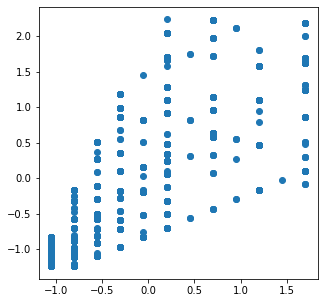

In [108]:
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 2]) #qty and total sum
plt.show()

In [109]:
X_new =X[:, [1,2]] #qty and total sum
X_new.shape

(2504, 2)

In [118]:
def init_gmm(X, k):
    m = X.shape[0]
    n = X.shape[1]
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    np.random.seed(40)
    order = np.random.permutation(m)
    for j in range(k):
        # Initially assign equal probability to each cluster/outcome
        Phi[j] = 1/k      
        # Ramdomly assign mean to one of the data points       
        Mu[:,j] = X[order[j],:].T
        # Initial covariance is identity matrix
        Sigma[j,:,:] = np.eye(n)    
    return Phi, Mu, Sigma


def Gaussian(X, mean, covariance):
    k = len(mean)
    X = X - mean.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * np.sum(X @ np.linalg.inv(covariance) * X, axis=1))
    return p

def Mahalanobis_distance(X, mean, covariance):
    X = X - mean.T
    ans = np.sqrt(np.sum(X @ np.linalg.inv(covariance) * X, axis=1))
#     print(ans)
    return ans
    

# Run one iteration of EM
def iterate_em_gmm(X, threshold, Phi, Mu, Sigma):
    m = X.shape[0]
    n = X.shape[1]
    k = len(Phi)
    threshold = np.reshape(np.repeat(threshold, n*k), (n,k))
    pj_arr = np.zeros((m,k))
    
    # E-step: calculate w_j^i
    W = np.zeros((m, k))
    for j in range(k):
        pj = Gaussian(X, Mu[:,j], Sigma[j,:,:])
        pj_arr[0:m,j] = pj
        W[:,j] = Phi[j] * pj

    # W tells us what is the relative weight of each cluster for each data point
    W[:,:] = W * np.tile(1/np.sum(W,1),(k,1)).T

    # M-step: adjust mean and sigma
    Phi[:] = sum(W) / m
    Mu_previous = Mu.copy()
    for j in range(k):
        # Split cluster specific W for each dimension
        Wj = np.tile(W[:,j],(n,1)).T
        # Compute Mu for each variable for each cluster
        Mu[:,j] = sum(X * Wj)/sum(Wj)
        Muj = np.tile(Mu[:,j],(m,1))
        Sigma[j,:,:] = np.matmul((X - Muj).T, (X - Muj) * Wj) / sum(W[:,j])

    if (abs(Mu-Mu_previous) <= threshold).all():
        converged = True
    else:
        converged = False
        

    labels = np.argmax(pj_arr, axis = 1)
    pj = pj_arr[np.arange(0,m,1),labels]
    X_label = np.insert(X, 2, labels, axis=1)
    return converged, pj, X_label


In [124]:
k = 3
Phi, Mu, Sigma = init_gmm(X_new, k)
threshold = threshold = np.matrix(.1)
converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X_new, threshold, Phi, Mu, Sigma)

In [125]:
print(Mu.shape)
m_distance = np.zeros((X_new.shape[0],Mu.shape[1]))

for kk in range(Mu.shape[1]):
    for i, x in enumerate(X_new):
        # get all row data from target column
        mu = Mu[:,kk]
        # get target sigma
        sig = Sigma[kk,:,:]
        # inverse matrix of sigma
        sig_inv = np.linalg.inv(sig)
        # find difference of mu and x and reshape it (if need)
        diff = (x - mu).reshape(-1,1)
        # calculate distance from diff and sigma
        distance = np.sqrt(np.dot(np.dot(diff.T, sig_inv),diff))
        # keep distance
        m_distance[i,kk] = distance

# find unique of minimum m_distance and count
# hint: use np.unique and np.argmin
(unique, counts) = np.unique(np.argmin(m_distance,axis=1)), len(np.unique(np.argmin(m_distance,axis=1)))

max_z_score = 2
# find minimum distance
# hint: use np.min
min_distance = np.min(m_distance, axis=1)
# find outlier from min_distance
outlier = np.where(min_distance > max_z_score)

(2, 3)


(2504, 2)


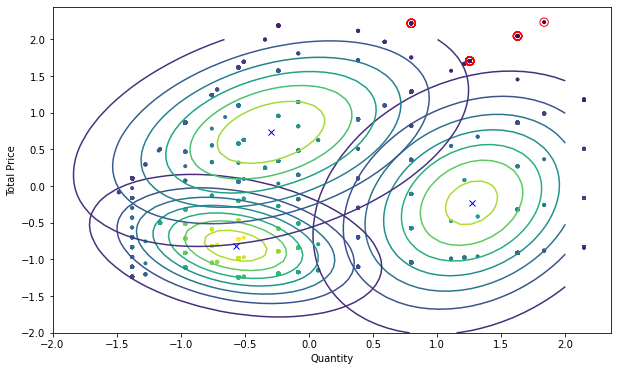

In [126]:
print(X_new.shape)
# Test function: Do not remove
# print('outlier', outlier)

plt.figure(figsize=(10,6))
plt.scatter(X_new[:,0],X_new[:,1],marker=".",c=pj,cmap='viridis');

plt.scatter(X_new[outlier,0],X_new[outlier,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

for c in np.arange(0,k):    
    X_class = X_new[np.where(X_label[:,2] == c)[0],:]
    xlist = np.linspace(-2, 2, 50)
    ylist = np.linspace(-2, 2, 50)
    
    XX, YY = np.meshgrid(xlist, ylist)
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
#             print("pt", pt)
#             print("mu", Mu[:2,c])
#             print(Sigma)
            Z[i,j] = Gaussian(pt, Mu[:2,c], Sigma[c])
            j = j + 1
        i = i + 1    
        
    cp = plt.contour(XX, YY, Z)
plt.xlabel('Quantity')
plt.ylabel('Total Price')
plt.show()
# End test function

Using 3 clusters  we can see that we have groups with
 - high unit price and avg quantity
 - avg quantity and low unit price
 - high qunaity and low unit price
 
 cluster 2 and 3 are overlapping a lot

In [137]:
def cost(X_label, Mu):
    loss = np.inf
    for j in range(Mu.shape[1]) : 
        Muj = Mu.T[j]
        Xj = X_label[X_label[:, -1] == j][:, :-1]
        loss = min(loss, np.min(np.linalg.norm(Xj-Muj)))
    return loss

likelihood = []
for k in range(1,4):
    threshold = np.matrix(.01)

    Phi, Mu, Sigma = init_gmm(X_new, k)

    converged = False
    while not converged:
        converged, pj, X_label = iterate_em_gmm(X_new, threshold, Phi, Mu, Sigma)
    loss = cost(X_label, Mu)
    likelihood.append(loss)

In [138]:
likelihood

[70.76722405181653, 36.56522309162292, 21.849150520173385]

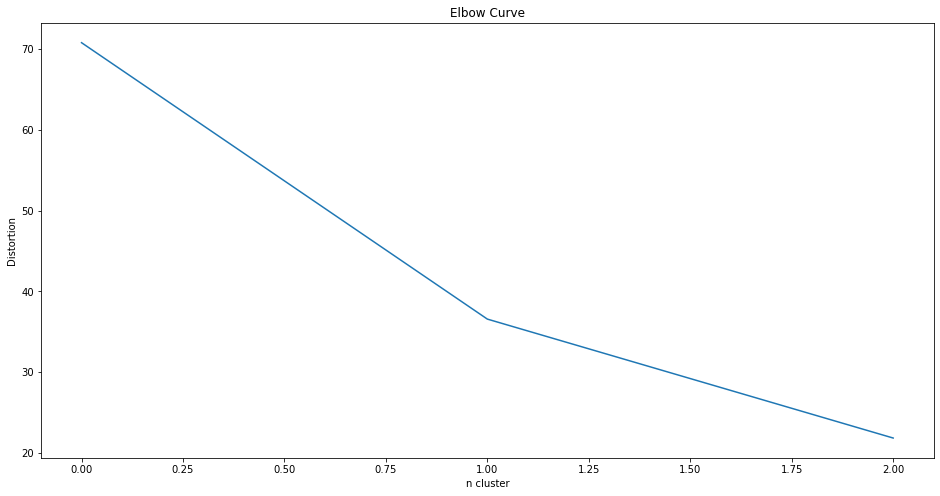

In [146]:
likelihood = np.array(likelihood)
plt.figure(figsize=(16,8))
plt.plot(likelihood)
plt.xlabel('n cluster')
plt.ylabel('Distortion')
plt.title('Elbow Curve')
plt.show()

The cluster seems optimum at 2 or 3 so either will work. It makes sense because the clusters 2 and 3 were almost the same in the previous plot.